## AutoEncoder를 사용한 이상 탐지

### 이상치 분류

In [81]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

#csv 파일 불러오기
ambi_temp=pd.read_csv("/content/ambient_temperature_system_failure.csv")
print(ambi_temp.describe())

#날짜 dtype으로 변경
ambi_temp['timestamp'] = pd.to_datetime(ambi_temp['timestamp'])

             value
count  7267.000000
mean     71.242433
std       4.247509
min      57.458406
25%      68.369411
50%      71.858493
75%      74.430958
max      86.223213


##### 사분위수 (IQR)

normal     7229
outlier      38
Name: outlier_IQR, dtype: int64


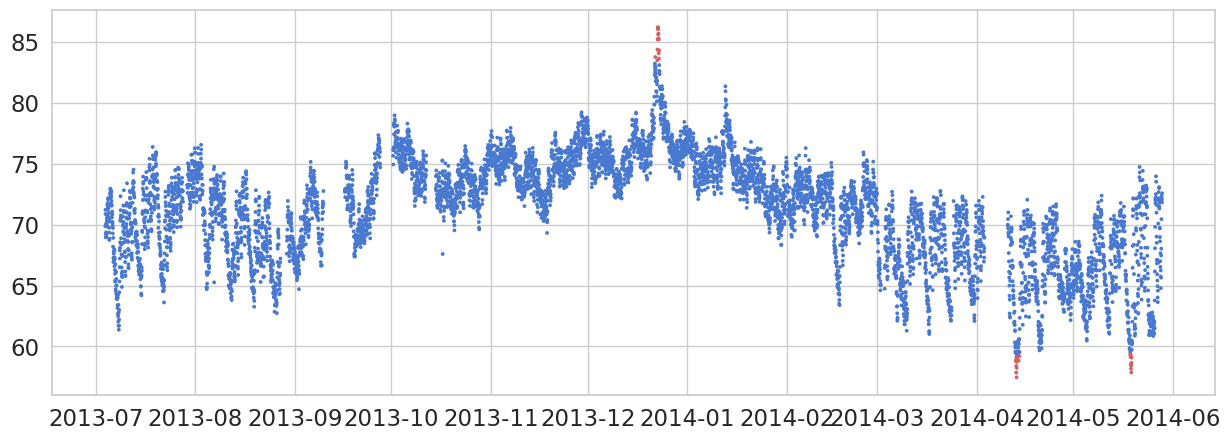

In [83]:
#사분위 수로 이상치 찾기
#Q1-IQR*1.5 이하 또는 Q3+IQR*1.5 = 이상치로 간주
ambi_temp["outlier_IQR"]=["outlier" if i<59.35 or i>83.44 else "normal" for i in ambi_temp["value"]]
print(ambi_temp["outlier_IQR"].value_counts())
ambi_temp["color_IQR"] = ['r' if i == "outlier" else "b" for i in ambi_temp["outlier_IQR"]]
plt.figure(figsize=(15,5))
plt.scatter(ambi_temp['timestamp'], ambi_temp['value'], c=ambi_temp['color_IQR'],s=3)

##### 정규 분포 (Normal distribution)

             value  scaled_value
count  7267.000000  7.267000e+03
mean     71.242433  7.352802e-16
std       4.247509  1.000069e+00
min      57.458406 -3.245426e+00
25%      68.369411 -6.764482e-01
50%      71.858493  1.450503e-01
75%      74.430958  7.507328e-01
max      86.223213  3.527199e+00
normal     6808
outlier     459
Name: outlier_3sd, dtype: int64


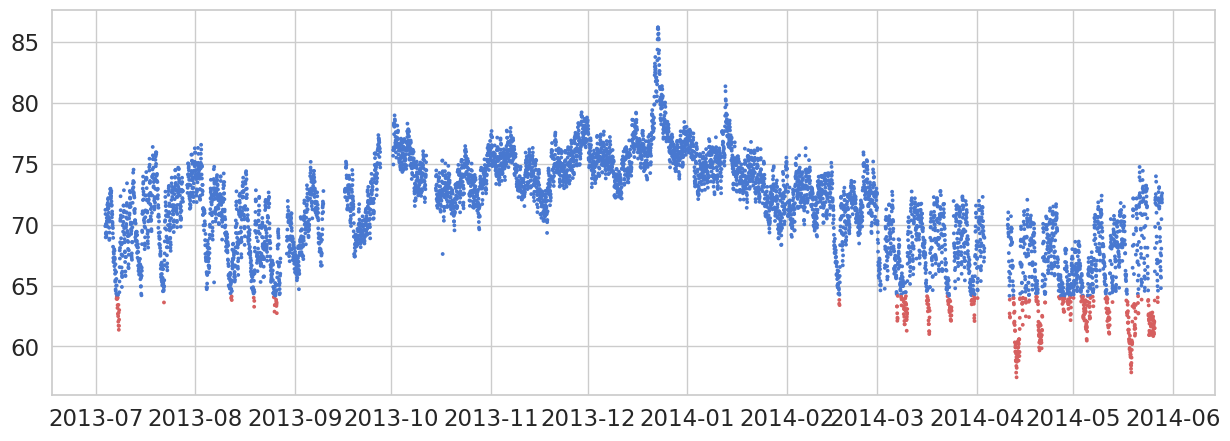

In [84]:
#정규 분포 + or - 3표준편차로 이상치 구분
#Scaling
scaler = StandardScaler()
scaler.fit(ambi_temp[['value']])
ambi_temp["scaled_value"] = scaler.transform(ambi_temp[['value']])

print(ambi_temp.describe()) #표준편차 값 확인

ambi_temp["outlier_3sd"]=["outlier" if i<-1.67 or i>8.5 else "normal" for i in ambi_temp["scaled_value"]]
print(ambi_temp["outlier_3sd"].value_counts()) #이상치 개수 확인
ambi_temp["color_3sd"] = ["r" if i == "outlier" else "b" for i in ambi_temp["outlier_3sd"]]
plt.figure(figsize=(15,5))
plt.scatter(ambi_temp['timestamp'], ambi_temp['value'], c=ambi_temp['color_3sd'],s=3)

##### LSTM AutoEncoder로 이상치 탐지하기 (Unsupervised Learning)

In [ ]:
#모델 설계
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Dense


""" LSTM encoder """
class Encoder(Model):

    def __init__(self, seq_length, latent_dim):
        super(Encoder, self).__init__()

        self.h1 = LSTM(128, return_sequences=True)
        self.h2 = LSTM(latent_dim, return_sequences=False)
        self.h3 = RepeatVector(seq_length)

    def call(self, x):
        x = self.h1(x)
        z = self.h2(x)
        z_rep = self.h3(z)

        return z, z_rep

""" LSTM decoder """
class Decoder(Model):

    def __init__(self, input_dim, latent_dim):
        super(Decoder, self).__init__()

        self.h1 = LSTM(latent_dim, return_sequences=True)
        self.h2 = LSTM(128, return_sequences=True)
        self.h3 = TimeDistributed(Dense(input_dim))

    def call(self, x):
        x = self.h1(x)
        x = self.h2(x)
        x = self.h3(x)

        return x


""" LSTM AE """
class LstmAE(Model):

    def __init__(self, seq_length, input_dim, latent_dim):
        super(LstmAE, self).__init__()

        self.encoder = Encoder(seq_length, latent_dim)
        self.decoder = Decoder(input_dim, latent_dim)

    def call(self, x):
        z, z_rep = self.encoder(x)
        decoded = self.decoder(z_rep)

        return decoded

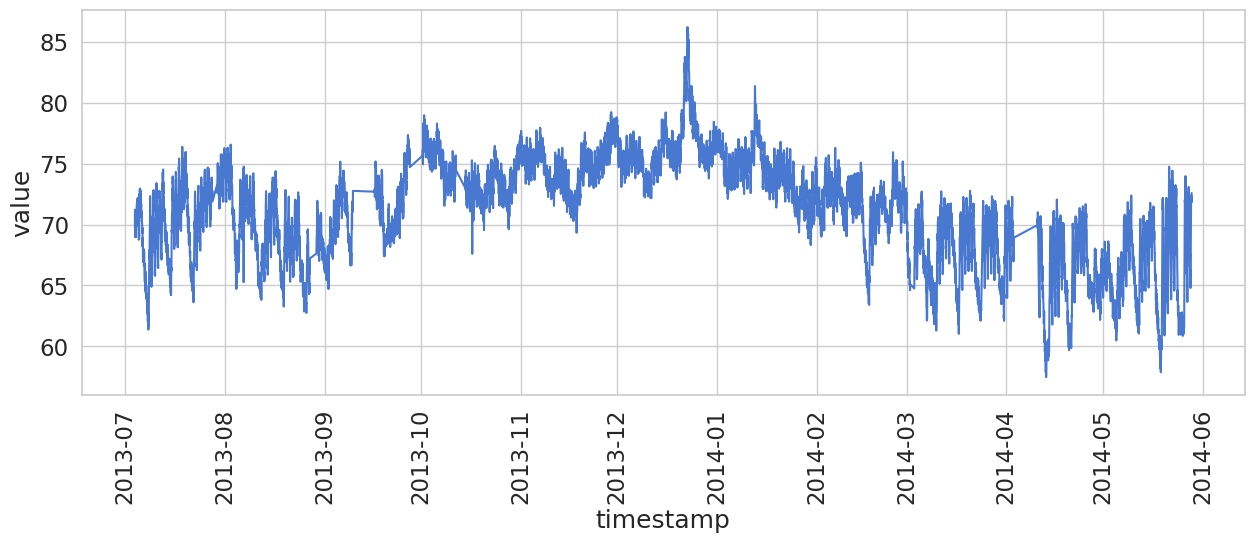

[-0.47935665 -0.14206862 -0.22829796 -0.71139407 -0.62976578]                         value
timestamp                    
2013-07-04 00:00:00 -0.479357
2013-07-04 01:00:00 -0.142069
2013-07-04 02:00:00 -0.228298
2013-07-04 03:00:00 -0.711394
2013-07-04 04:00:00 -0.629766
Epoch 1/100
184/184 - 52s - loss: 0.1622 - val_loss: 0.3201 - 52s/epoch - 281ms/step
Epoch 2/100
184/184 - 28s - loss: 0.0759 - val_loss: 0.1446 - 28s/epoch - 151ms/step
Epoch 3/100
184/184 - 24s - loss: 0.0455 - val_loss: 0.1019 - 24s/epoch - 133ms/step
Epoch 4/100
184/184 - 26s - loss: 0.0322 - val_loss: 0.0776 - 26s/epoch - 144ms/step
Epoch 5/100
184/184 - 26s - loss: 0.0290 - val_loss: 0.0582 - 26s/epoch - 139ms/step
Epoch 6/100
184/184 - 27s - loss: 0.0281 - val_loss: 0.0517 - 27s/epoch - 149ms/step
Epoch 7/100
184/184 - 28s - loss: 0.0250 - val_loss: 0.0452 - 28s/epoch - 153ms/step
Epoch 8/100
184/184 - 29s - loss: 0.0249 - val_loss: 0.0507 - 29s/epoch - 156ms/step
Epoch 9/100
184/184 - 27s - loss: 0.0253 - val_l

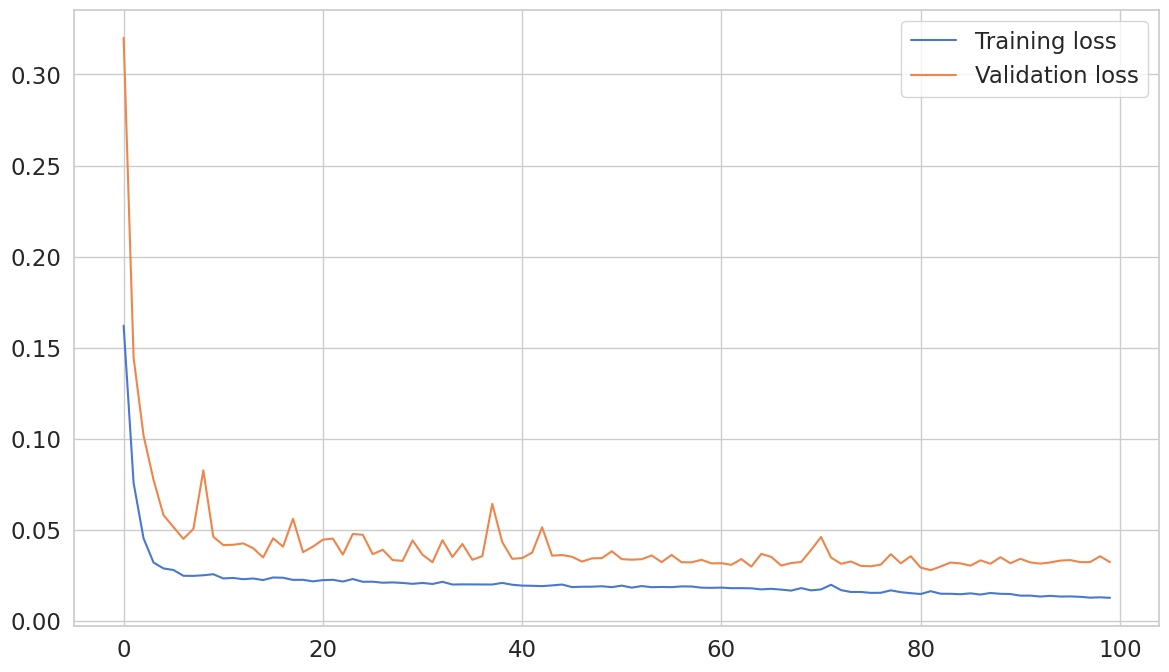

In [ ]:
#학습

import os
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

config ={}
config['seq_len'] = 30
config['latent_dim'] = 64

""" loading training and test stock data """
def get_data(grimOn=1):

    data = pd.read_csv('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/NAB/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv')

    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)

    if grimOn:
        fig, ax = plt.subplots(figsize=(15,5))

        sns.lineplot(x=data.index, y=data['value'], ax=ax)

        ax.xaxis.set_major_locator(mdates.MonthLocator())

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

        plt.xticks(rotation=90)

        plt.show()

    # split the data
    train = data.loc[:'2014-04-28 08:00:00'].copy()
    test = data.loc['2014-04-28 09:00:00':].copy()

    # 정규화화
    scaler = StandardScaler()
    scaler = scaler.fit(train[['value']])

    train.loc[:, 'value'] = scaler.transform(train[['value']])
    test.loc[:, 'value'] = scaler.transform(test[['value']])
    data.loc[:, 'value'] = scaler.transform(data[['value']])

    return train, test, scaler, data


""" change stock data to sequenlosstial data for LSTM input """
def to_sequences(x, seq_len=1):

    X = []

    for i in range(len(x) - seq_len):
        X.append(x.iloc[i:(i + seq_len)].values)

    return np.array(X)


def train():

    train, test, scaler, _ = get_data(grimOn=1)

    seq_len = config['seq_len']
    latent_dim = config['latent_dim']

    trainX = to_sequences(train[['value']], seq_len)
    print(trainX[0:5,0, 0], train.head(5))

    input_dim = trainX.shape[2]

    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)

    lstm_ae = LstmAE(seq_len, input_dim, latent_dim)
    lstm_ae.compile(optimizer=optimizer, loss='mse')

    history = lstm_ae.fit(trainX, trainX, epochs=100, batch_size=32, validation_split=0.1, verbose=2)

    lstm_ae.save_weights("/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/NAB/lstm_ae.h5")

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()


if __name__ == "__main__":

    train()

22/22 [==============================] - 3s 45ms/step


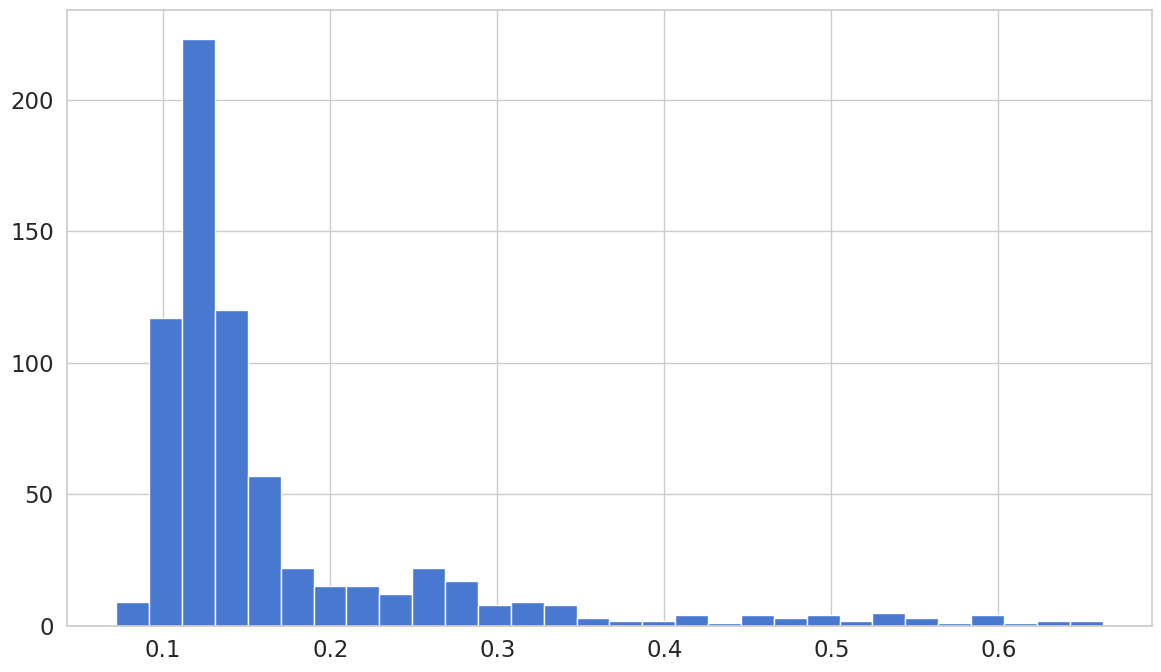

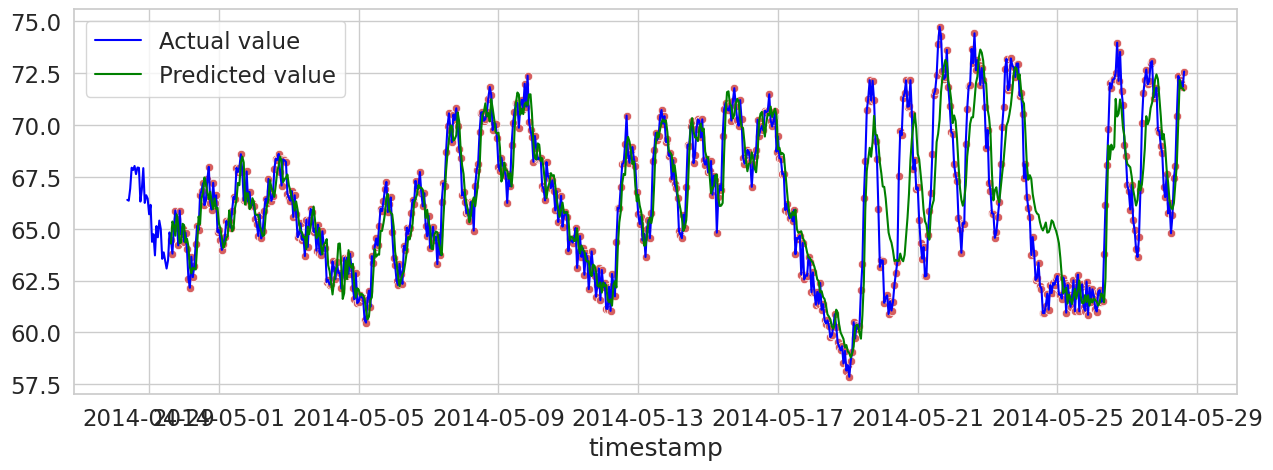

In [ ]:
# LSTM AE model 평가


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def eval(lstm_ae, scaler, train, trainX):

    if os.path.exists('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/NAB/lstm_ae.h5'):
        lstm_ae.load_weights("/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/NAB/lstm_ae.h5")
    else:
        return 0

    trainPredict = lstm_ae.predict(trainX)

    trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)

    plt.hist(trainMAE, bins=30)
    plt.show()

    close_feature_index = 0

    predicted_prices = trainPredict[:, -1, close_feature_index].reshape(-1, 1)
    print(predicted_prices.shape, trainPredict.shape)

    predicted_prices = scaler.inverse_transform(predicted_prices)

    plt.figure(figsize=(15, 5))
    plt.plot(train.index, scaler.inverse_transform(train['value'].values.reshape(-1, 1)), color='blue',
             label='Actual value')
    plt.plot(train.index[len(train.index) - len(predicted_prices):], predicted_prices, color='red',
             label='Predicted value')
    plt.legend()
    plt.show()


def detect(lstm_ae, seq_len, scaler, max_trainMAE, test, testX):

    if os.path.exists('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/NAB/lstm_ae.h5'):
        lstm_ae.load_weights("/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/NAB/lstm_ae.h5")
    else:
        return 0

    testPredict = lstm_ae.predict(testX)
    testMAE = np.mean(np.abs(testPredict - testX), axis=1)

    plt.hist(testMAE, bins=30)
    plt.show()

    close_feature_index = 0

    predicted_prices = testPredict[:, -1, close_feature_index].reshape(-1, 1)

    predicted_prices = scaler.inverse_transform(predicted_prices)

    plt.figure(figsize=(15, 5))
    plt.plot(test.index, scaler.inverse_transform(test['value'].values.reshape(-1, 1)), color='blue',
             label='Actual value')
    plt.plot(test.index[len(test.index) - len(predicted_prices):], predicted_prices, color='green',
             label='Predicted value')
    plt.legend()

    anomaly_df = pd.DataFrame(test[seq_len:])
    anomaly_df['testMAE'] = testMAE
    anomaly_df['max_trainMAE'] = max_trainMAE
    anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
    anomaly_df['value'] = test[seq_len:]['value']

    anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

    if not anomalies.empty:
        sns.scatterplot(x=anomalies.index,
                        y=scaler.inverse_transform(anomalies['value'].values.reshape(-1, 1)).flatten(),
                        color='r')

    plt.show()


if __name__ == "__main__":

    seq_len = config['seq_len']
    latent_dim = config['latent_dim']

    train, test, scaler, data = get_data(grimOn=0)

    trainX = to_sequences(train[['value']], seq_len)
    testX = to_sequences(test[['value']], seq_len)
    dataX = to_sequences(data[['value']], seq_len)

    input_dim = trainX.shape[2]

    lstm_ae = LstmAE(seq_len, input_dim, latent_dim)
    lstm_ae.build(input_shape=(None, seq_len, input_dim))

    ev = 0
    if ev == 1:
        eval(lstm_ae, scaler, train, trainX)
    else:
        max_trainMAE = 0.015
        detect(lstm_ae, seq_len, scaler, max_trainMAE, test, testX)

데이터 새로 불러오기

In [92]:
data=pd.read_csv("/content/ambient_temperature_system_failure.csv")
data['timestamp'] = pd.to_datetime(data['timestamp']) #시간 dtype으로 변경

##### Elbow method

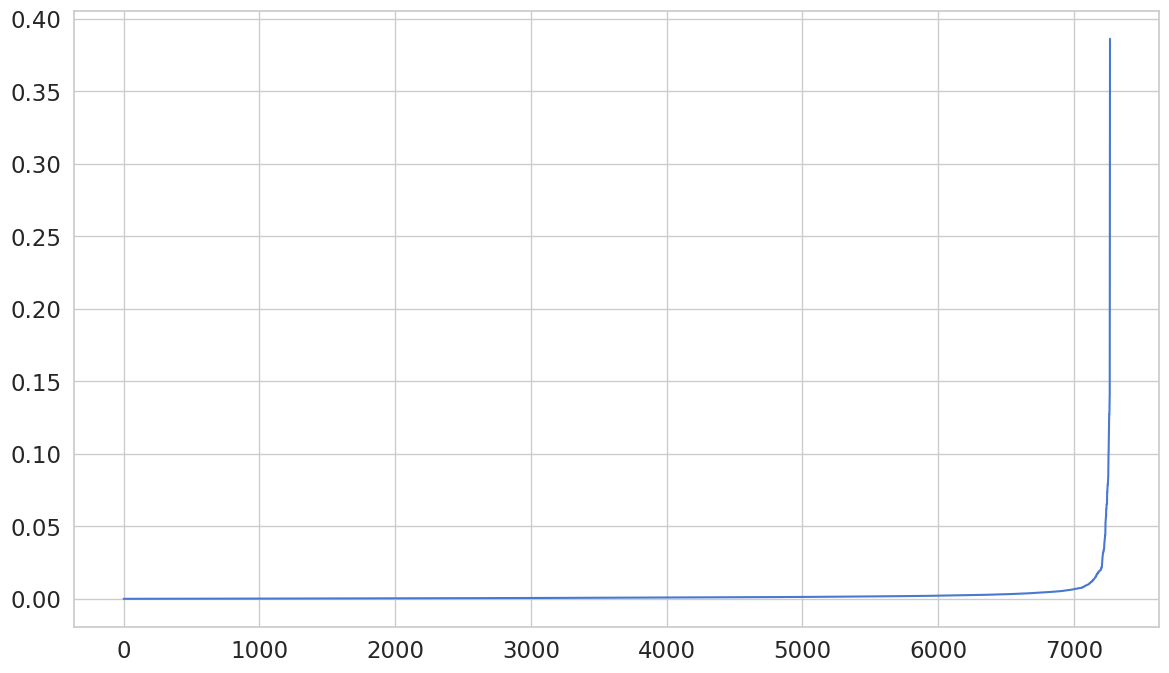

In [93]:
#elbow method로 적절한 eps값 확인
from sklearn.neighbors import NearestNeighbors
import numpy as np
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(pd.DataFrame(data["value"]))
distances, indices = nbrs.kneighbors(pd.DataFrame(data["value"]))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [98]:
#DBSCAN으로 이상치 labeling
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.03)
predict = dbscan.fit_predict(pd.DataFrame(data["value"]))

data["dbscan_result"]=predict
data["outlier"]=data["dbscan_result"].apply(lambda x: 'normal' if x==0 else "outlier")
print(data["outlier"].value_counts())

normal     6783
outlier     484
Name: outlier, dtype: int64


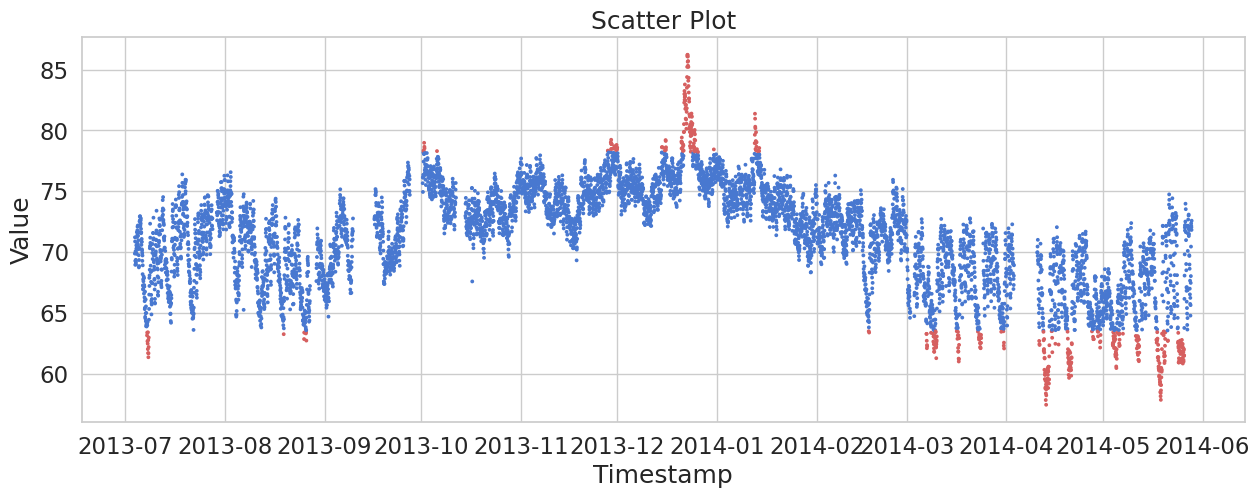

In [99]:
#이상치 시각화
plt.figure(figsize=(15,5))

data["color"] = ["r" if i == "outlier" else "b" for i in data["outlier"]]
plt.scatter(data['timestamp'], data['value'], c=data['color'],s=3)
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Scatter Plot')
plt.show()

### AutoEncoder Modeling

In [104]:
#모듈 호출
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.activations import sigmoid

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 15, 5

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["normal", "outlier"]

##### preprocessing

In [101]:
#필요한 열만 추출
data=data.iloc[:,[0,1,3]]

#문자열 값 수치화 (outlier=1, normal=0)
data["class"]=data["outlier"].apply(lambda x: 1 if x=="outlier" else 0)

#정규화
from sklearn.preprocessing import StandardScaler
data['value'] = StandardScaler().fit_transform(data['value'].values.reshape(-1, 1))

#학습에 사용하지 않을 열 삭제
data = data.drop(['timestamp'], axis=1)
data = data.drop(['outlier'], axis=1)

#데이터 확인
data.head()

##### train test split

In [63]:
#8:2 (train, test) 비율로 split
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train["class"] == 0] #정상 값만 학습에 사용
X_train = X_train.drop(['class'], axis=1) #비지도 학습

y_test = X_test['class'] #class 값 추출
X_test = X_test.drop(['class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(4869, 1)

##### make model

In [72]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

##### keras에서 제공해주지 않는 metric f1 score 함수 구현

In [73]:
from keras import backend as K

def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))

    count_true_positive = K.sum(y_target_yn * y_pred_yn)
    count_true_positive_false_negative = K.sum(y_target_yn)

    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    return recall


def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1))

    count_true_positive = K.sum(y_target_yn * y_pred_yn)
    count_true_positive_false_positive = K.sum(y_pred_yn)

    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)

    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())

    return _f1score

### Train

In [74]:
nb_epoch = 100
batch_size = 16
autoencoder.compile(optimizer='adam',
                    loss='mean_absolute_error',
                    metrics=[f1score])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=1,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                            histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
305/305 [==============================] - ETA: 0s - loss: 0.2482 - f1score: 0.9347
Epoch 1: val_loss improved from inf to 0.40964, saving model to model.h5
305/305 [==============================] - 2s 3ms/step - loss: 0.2482 - f1score: 0.9347 - val_loss: 0.4096 - val_f1score: 0.9969
Epoch 2/100
300/305 [============================>.] - ETA: 0s - loss: 0.2051 - f1score: 0.9968
Epoch 2: val_loss improved from 0.40964 to 0.40408, saving model to model.h5
305/305 [==============================] - 1s 3ms/step - loss: 0.2044 - f1score: 0.9966 - val_loss: 0.4041 - val_f1score: 1.0000
Epoch 3/100
301/305 [============================>.] - ETA: 0s - loss: 0.2029 - f1score: 0.9963
Epoch 3: val_loss improved from 0.40408 to 0.40258, saving model to model.h5
305/305 [==============================] - 1s 3ms/step - loss: 0.2030 - f1score: 0.9963 - val_loss: 0.4026 - val_f1score: 0.9929
Epoch 4/100
287/305 [===========================>..] - ETA: 0s - loss: 0.2009 - f1score: 0.9964
Ep

In [75]:
model_path= 'model.h5'
autoencoder = load_model(model_path, compile=False)
autoencoder.compile(optimizer='adam',
                    loss='mean_absolute_error',
                    metrics=[precision, recall, f1score])

##### train, test loss 시각화

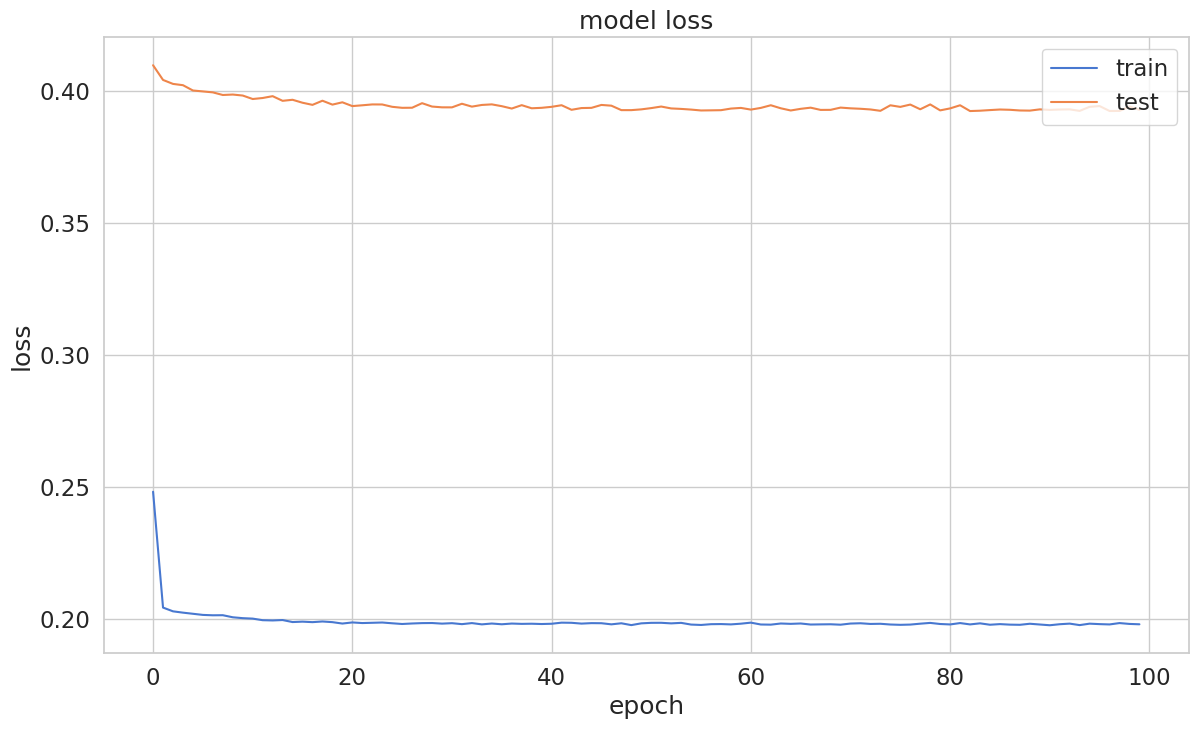

In [76]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### 성능 확인

In [78]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

##### predict

In [105]:
predictions = autoencoder.predict(X_test)
mae = np.mean(abs(X_test - predictions), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mae,
                        'true_class': y_test})

46/46 [==============================] - 0s 3ms/step


##### ROC Curve 그래프

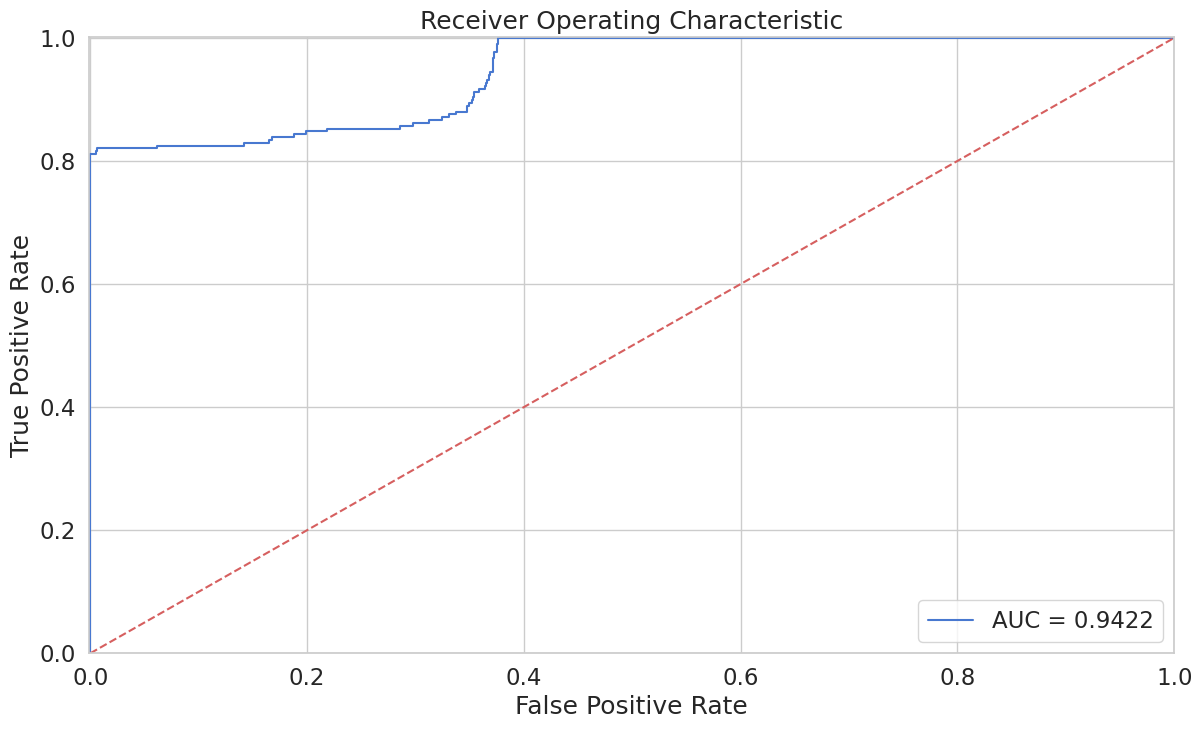

In [79]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

##### Confusion Matrix

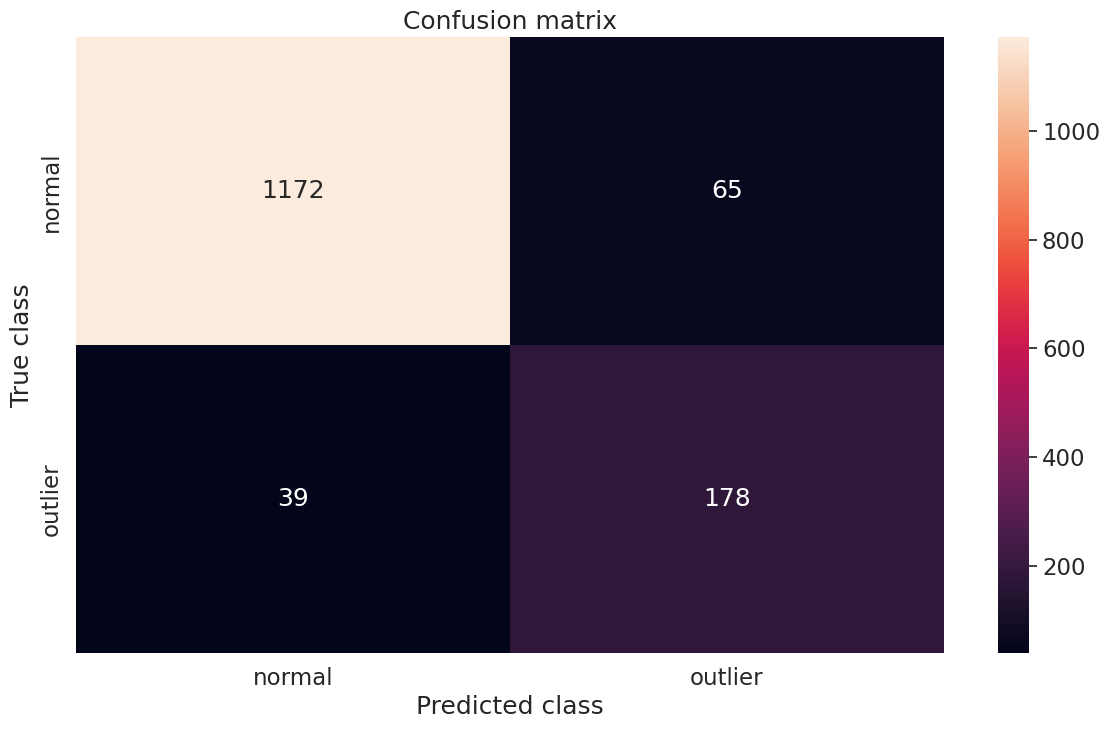

In [80]:
y_pred = [1 if e > 1 else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure()
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()